# AE, AEConv, VAE

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [25]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    transform_valid = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])


    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader



In [26]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, valid_loader, test_loader=mnist(batch_sz)

# Autoencoder

## AE class

In [27]:
class AE(nn.Module):
  def __init__(self, dz):
    super().__init__()
    self.en1 = nn.Linear(784, 500)
    self.ebn1 = nn.BatchNorm1d(500) #BatchNorm1d is Batch Normalization, which is one of the common Regularization techniques.
    self.en2 = nn.Linear(500, 100)              #constructing the encoder's layers for it to be used by the encoder later
    self.ebn2 = nn.BatchNorm1d(100)
    self.en3 = nn.Linear(100, dz)

    self.de1 = nn.Linear(dz, 100)
    self.dbn1 = nn.BatchNorm1d(100)
    self.de2 = nn.Linear(100, 500)
    self.dbn2 = nn.BatchNorm1d(500)
    self.de3 = nn.Linear(500, 784)

  def encoder(self, x):
    x = x.view(-1, 28 * 28) # reshaping to ensure the 2d image is flattened before it goes into the first linear layer of the encoder
    x = self.en1(x)
    x = torch.sigmoid(x) # sigmoid is a very convenient activation function to use here because it also works with values limited to the range of 0 to 1.
    x = self.ebn1(x)

    x = self.en2(x)
    x = torch.sigmoid(x)
    x = self.ebn2(x)

    x = self.en3(x)
    x = torch.sigmoid(x)
    return x

  def decoder(self, z):
    z = self.de1(z)
    z = torch.sigmoid(z)
    z = self.dbn1(z)

    z = self.de2(z)
    z = torch.sigmoid(z)
    z = self.dbn2(z)

    z = self.de3(z)
    z = torch.sigmoid(z)
    return z

  def forward(self, x):
    z = self.encoder(x)
    xhat = self.decoder(z)
    xhat = xhat.view(-1, 1, 28,28) # reshaping back to a 2D matrix to output an actual image and not an array.
    return xhat



Typically, mean squared is used as the loss function for autoencoders. The  objective is to minimize the following:
$$ L(x,\hat{x}) = \frac{1}{N} \sum^{N}_{i=1} ||x_{i}-\hat{x}_{i}||^{2} $$

## Train

21.172573941294104
7.861344764009118
6.9332390492782
6.407114448957145
6.032370180822909
5.765495021827519
5.5207030307501554
5.293619031785056
5.108986544422805
4.959308356279507
4.827867577550933
4.7086001662537456
4.596190539188683
4.489092124858871
4.391208753688261
4.304744188673794
4.226054204395041
4.152783501427621
4.083690607920289
4.018453262746334


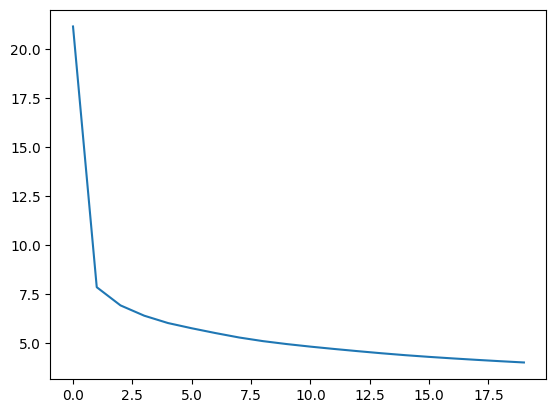

In [28]:
device = torch.device("cuda:0")
dz = 100
net = AE(dz).to(device)
opt = optim.Adam(net.parameters(), lr = 1e-3)
num_epochs = 20

ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X = batch[0].to(device) # we don't extract y here because this is unsupervised learning - we don't use labels.
    Xhat = net(X)
    loss = F.mse_loss(Xhat, X)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss)
  print(total_loss)
plt.plot(ls)





## Plot a comparison of original images and reconstructed images

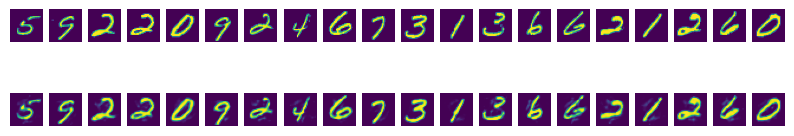

In [29]:
plt.figure(figsize=(10,2))
for i in range(20):
  plt.subplot(2, 20, i+1)
  plt.imshow(X[i,0,:,:].detach().cpu())
  plt.axis("off")
  plt.subplot(2, 20, i+21)
  plt.imshow(Xhat[i,0,:,:].detach().cpu())
  plt.axis("off")

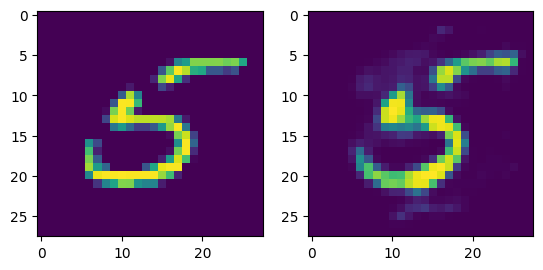

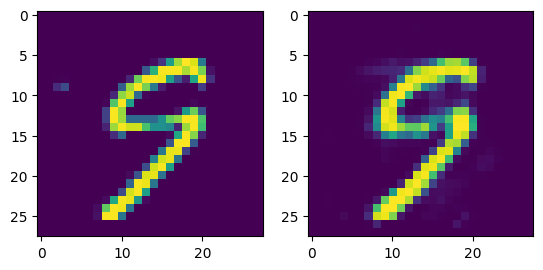

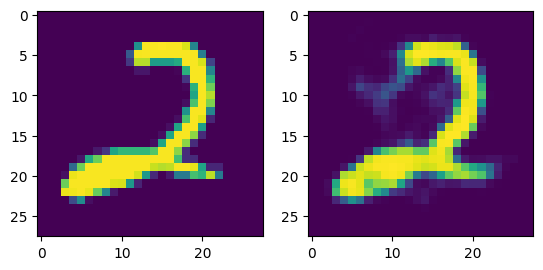

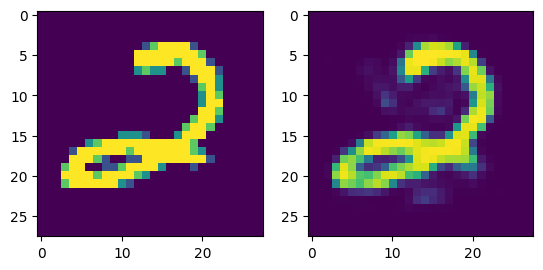

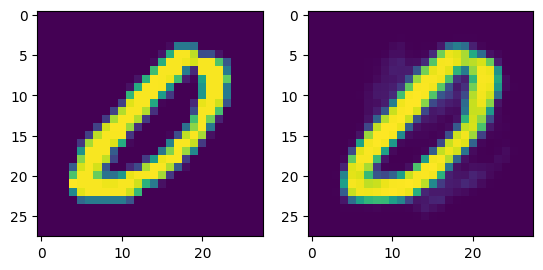

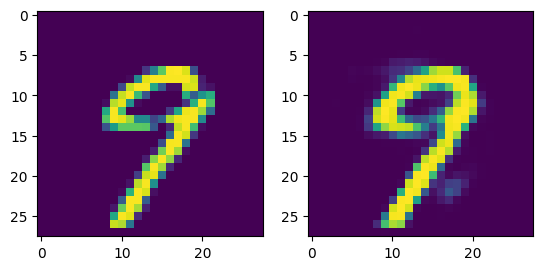

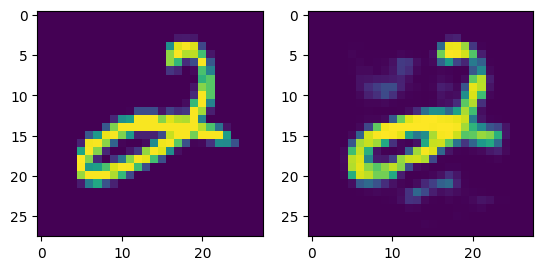

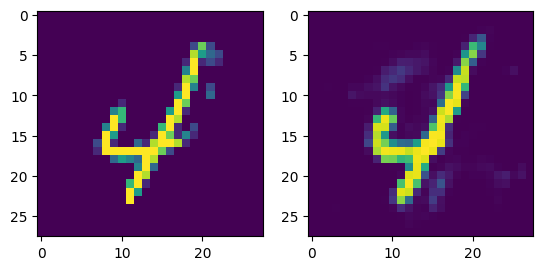

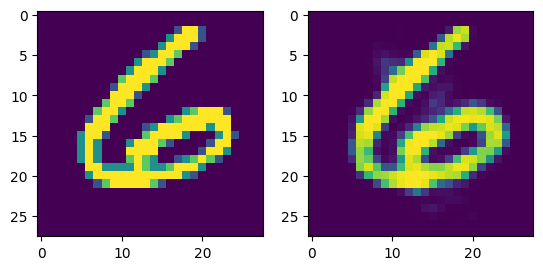

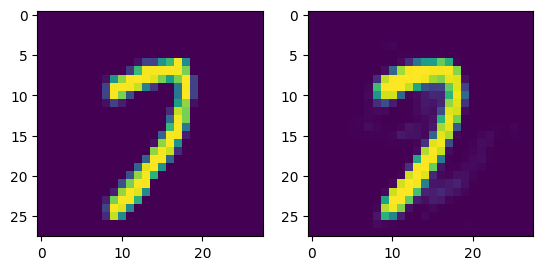

In [30]:
for i in range(10):
  plt.figure()
  plt.subplot(121)
  plt.imshow(X[i,0,:,:].detach().cpu())
  plt.subplot(122)
  plt.imshow(Xhat[i,0,:,:].detach().cpu())

# Convolutional Autoencoder

## AEConv class

In [31]:
class AEConv(nn.Module):
  def __init__(self, dz):
    super().__init__()
    self.dz = dz
    self.econv1 = nn.Conv2d(1, 16, 3, 1, 1) # 1 channel (the images are grayscale), 16 hidden neurons, kernel_size (filter_size) = 3, stride = 1, padding = 1.
    self.ebn1 = nn.BatchNorm2d(16)
    self.econv2 = nn.Conv2d(16, 32, 3, 2, 1) # a stride of 2 works as the downsampler here, like MaxPool2d(2, 2). This is downsampling the image by half. {32, 14, 14}
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32, 64, 3, 2, 1) # downsampled by half again. {64, 7, 7}
    self.ebn3 = nn.BatchNorm2d(64)
    self.elinear1 = nn.Linear(64*7*7, 100) # the first argument cannot be determined unless you grab a pen and paper and see how the dimensions of the image are changing.
    self.ebn4 = nn.BatchNorm1d(100)
    self.elinear2 = nn.Linear(100, self.dz)

    self.dlinear1 = nn.Linear(self.dz, 100)
    self.dbn1 = nn.BatchNorm1d(100)
    self.dlinear2 = nn.Linear(100,64*7*7)
    self.dbn2 = nn.BatchNorm1d(64*7*7)
    self.dconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding = 1) # ConvTranspose2d upsamples the images back again.
    self.dbn3 = nn.BatchNorm2d(32)
    self.dconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding = 1) # output_padding is needed when you realize it is needed when calculating output size using the equation taught in the bootcamp
    self.dbn4 = nn.BatchNorm2d(16)
    self.dconv3 = nn.ConvTranspose2d(16, 1, 3, 1, 1)


  def encoder(self, x):
    x = self.econv1(x)
    x = torch.sigmoid(x)
    x = self.ebn1(x)
    # x ---> (16, 28, 28)
    x = self.econv2(x)
    x = torch.sigmoid(x)
    x = self.ebn2(x)
    # x ---> (32, 14, 14)
    x = self.econv3(x)
    x = torch.sigmoid(x)
    x = self.ebn3(x)
    # x ---> (64, 7, 7)

    x = x.view(-1, 64*7*7)

    x = self.elinear1(x)
    x = torch.sigmoid(x)
    x = self.ebn4(x)

    x = self.elinear2(x)
    x = torch.sigmoid(x)
    return x


  def decoder(self, x):
    x = self.dlinear1(x)
    x = torch.sigmoid(x)
    x = self.dbn1(x)

    x = self.dlinear2(x)
    x = torch.sigmoid(x)
    x = self.dbn2(x)
    x = x.view(-1,64,7,7)

    x = self.dconv1(x)
    x = torch.sigmoid(x)
    x = self.dbn3(x)
    x = self.dconv2(x)
    x = torch.sigmoid(x)
    x = self.dbn4(x)

    x = self.dconv3(x)
    x = torch.sigmoid(x)
    return x





## Train

79.44737198390067
14.365518695674837
13.040475259535015
12.344275412149727
11.84143874514848
11.422064252197742
11.045000077225268
10.69311354495585
10.361494248732924
10.04748244350776
9.748079410288483
9.457306289114058
9.175854259636253
8.908143077045679
8.656807980965823
8.420457617845386
8.19784538820386
7.988910257816315
7.79456750722602


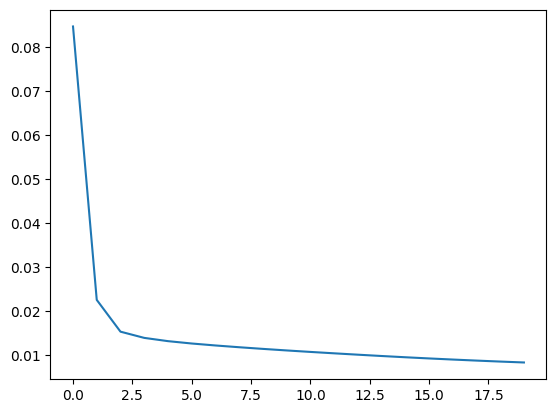

In [32]:
device = torch.device("cuda:0")
dz = 32
net = AEConv(dz).to(device)
num_epochs = 20
lr = 1e-4

optimizer = optim.Adam(net.parameters(), lr = lr)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X = batch[0].to(device)
    code = net.encoder(X)
    Xhat = net.decoder(code)
    loss = F.mse_loss(Xhat, X)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()


  ls.append(total_loss/len(train_loader))
  print(total_loss)

plt.plot(ls)


## Plot a comparison of original images and reconstructed images

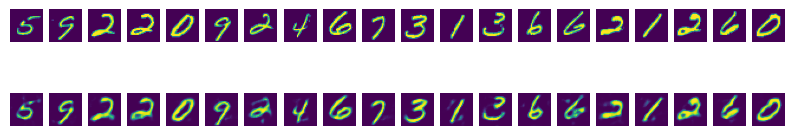

In [33]:
plt.figure(figsize=(10,2))
for i in range(20):
  plt.subplot(2, 20, i+1)
  plt.imshow(X.detach().cpu()[i,0,:,:])
  plt.axis("off")
  plt.subplot(2, 20, i+21)
  plt.imshow(Xhat.detach().cpu()[i,0,:,:])
  plt.axis("off")


# Variational Autoencoder

## VAE class

In [34]:
class VAE(nn.Module):
  def __init__(self, dz):
    super().__init__()
    self.dz = dz
    self.econv1 = nn.Conv2d(1, 16, 3, 1, 1)
    self.ebn1 = nn.BatchNorm2d(16)
    self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32, 64, 3, 2, 1)
    self.ebn3 = nn.BatchNorm2d(64)
    self.elinear1 = nn.Linear(64 * 7 * 7, 100)
    self.ebn4 = nn.BatchNorm1d(100)
    self.elinear2 = nn.Linear(100, self.dz)

    self.plinear1 = nn.Linear(self.dz, self.dz)
    self.plinear2 = nn.Linear(self.dz, self.dz)

    self.dlinear1 = nn.Linear(self.dz , 100)
    self.dbn1 = nn.BatchNorm1d(100)
    self.dlinear2 = nn.Linear(100, 64 * 7 * 7)
    self.dbn2 = nn.BatchNorm1d(64 * 7 * 7)
    self.dconv1 = nn.ConvTranspose2d(64, 32, 3, 1, 1)
    self.dbn3 = nn.BatchNorm2d(32)
    self.dconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding= 1)
    self.dbn4 = nn.BatchNorm2d(16)
    self.dconv3 = nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding= 1)

  def encoder_head(self, x):
    x = torch.sigmoid(self.econv1(x))
    x = self.ebn1(x)
    x = torch.sigmoid(self.econv2(x))
    x = self.ebn2(x)
    x = torch.sigmoid(self.econv3(x))
    x = self.ebn3(x)
    x = x.view(-1, 64 * 7 * 7)
    x = torch.sigmoid(self.elinear1(x))
    x = self.ebn4(x)
    x = torch.sigmoid(self.elinear2(x))
    return x

  def get_params(self, x):
    mu = self.plinear1(x)
    logvar = self.plinear2(x)
    return (mu, logvar)

  def reparm(self, mu, logvar):
    eps = torch.randn(mu.shape).to(device) # Gaussian noise (our "perfect" normal distribution with mean 0 and variance of 1)
    z = mu + eps * torch.exp(0.5 * logvar) # std = exp(0.5 * logvar)
    return z

  def decoder(self, x):
    x = torch.sigmoid(self.dlinear1(x))
    x = self.dbn1(x)
    x = torch.sigmoid(self.dlinear2(x))
    x = self.dbn2(x)
    x = x.view(-1, 64, 7, 7)
    x = torch.sigmoid(self.dconv1(x))
    x = self.dbn3(x)
    x = torch.sigmoid(self.dconv2(x))
    x = self.dbn4(x)
    x = torch.sigmoid(self.dconv3(x))
    return x

  def forward(self,x):
    x = self.encoder_head(x)
    mu, logvar = self.get_params(x)
    z = self.reparm(mu, logvar)
    x = self.decoder(z)
    return (z, mu, logvar, x)


## VAE loss function

In [35]:
def vae_loss(xhat, x, mu, logvar):
  KL_WEIGHT = 0.00012 # this tells the VAE how much it should depend on trying to minimize the difference between the learned distribution and the Gaussian distribution. The rest of the dependence would go to the reconstruction_loss.
  recon_loss = F.mse_loss(xhat, x)
  kl_loss = torch.mean(torch.sum(-0.5*(1+logvar - torch.exp(logvar) - mu*mu), axis =1), axis =0)
  return (1-KL_WEIGHT)*recon_loss + (KL_WEIGHT)*kl_loss

## Train

152.3381021618843
78.08173187822104
59.46994622796774
47.11502277851105
36.4896478690207
32.29501085355878
29.960392218083143
28.145282167941332
26.73649338260293
25.449713729321957
24.38631086423993
23.469212856143713
22.639417512342334
21.961691247299314
21.372797682881355
20.82100442238152
20.325285339727998
19.869016094133258
19.45136944949627
19.081814769655466


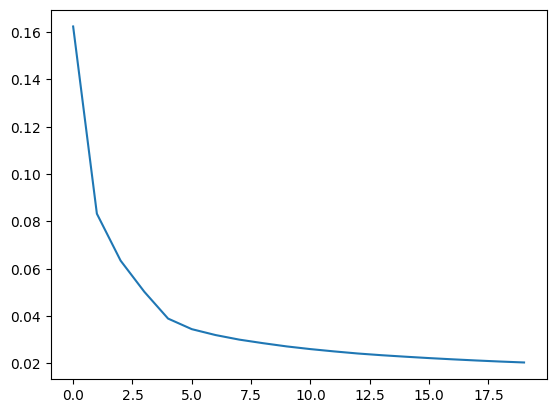

In [36]:
device = torch.device("cuda:0")
dz = 32
net = VAE(dz).to(device)
num_epochs = 20
lr = 1e-4
optimizer = optim.Adam(net.parameters(), lr = lr)

ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X = batch[0].to(device)
    Z, mu, logvar, Xhat = net(X)
    loss = vae_loss(Xhat, X, mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()


  ls.append(total_loss/len(train_loader))
  print(total_loss)

plt.plot(ls)


## Plot a comparison of X and its corresponding Xhat.

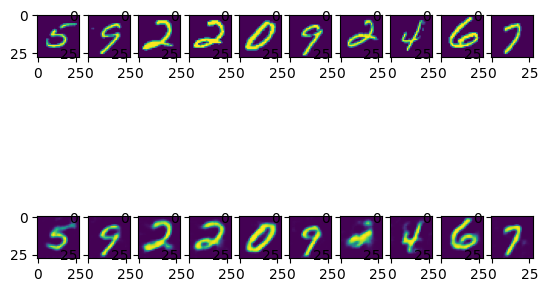

In [37]:
for i in range(10):
  plt.subplot(2, 10, i+1)
  plt.imshow(X.cpu()[i,0,:,:])
  plt.subplot(2,10,i+11)
  plt.imshow(Xhat[i,0,:,:].detach().cpu())

## Generate random samples

In [38]:
with torch.no_grad():
  net.eval()
  num_samples = 64

  z = torch.randn(num_samples, dz).to(device) # sampling random points (embedding vectors) from a normal distribution

  Xhat = net.decoder(z)

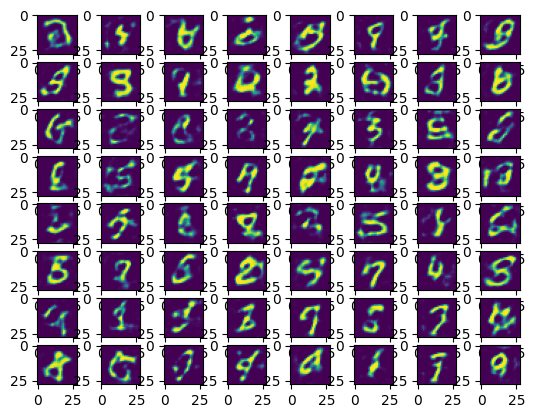

In [39]:
for i in range(num_samples):
  plt.subplot(8,8,i+1)
  plt.imshow(Xhat[i,0,:,:].detach().cpu())

In [40]:
#Q1: define a 2 layer simple NN for mnist digit classificaiton

In [41]:
#Q2: Define a CNN with 2 conv layer and 2 linear layers for mnist digit communication

In [42]:
#Q3: Train both networks for 10 epochs and compare their performance

In [43]:
#Q4: Compare the accuarcay of both networks on the test set

In [44]:
#Q5: go through the testset and plot some samples of incorrect results

In [45]:
#Q6: show the output of the intermediate layers

In [46]:
#Q7: Compare the time of training on CPU and GPU